<a href="https://colab.research.google.com/github/ggruszczynski/CFDPython/blob/master/lab40_diffusion_and_laplace_eq/13_Step_10_to_fill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[@LorenaABarba](https://twitter.com/LorenaABarba)

[@ggruszczynski](https://github.com/ggruszczynski)

12 steps to Navier–Stokes
=====
***

For a moment, recall the Navier–Stokes equations for an incompressible fluid, where $\vec{v}$ represents the velocity field:

$$
\begin{eqnarray*}
\nabla \cdot\vec{v} &=& 0 \\
\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v} &=& -\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}
\end{eqnarray*}
$$

The first equation represents mass conservation at constant density. The second equation is the conservation of momentum. But a problem appears: the continuity equation for incompressble flow does not have a dominant variable and there is no obvious way to couple the velocity and the pressure. In the case of compressible flow, in contrast, mass continuity would provide an evolution equation for the density $\rho$, which is coupled with an equation of state relating $\rho$ and $p$.

In incompressible flow, the continuity equation $\nabla \cdot\vec{v}=0$ provides a *kinematic constraint* that requires the pressure field to evolve so that the rate of expansion $\nabla \cdot\vec{v}$ should vanish everywhere. A way out of this difficulty is to *construct* a pressure field that guarantees continuity is satisfied; such a relation can be obtained by taking the divergence of the momentum equation. In that process, a Poisson equation for the pressure shows up!
See derivation on <http://www.thevisualroom.com/poisson_for_pressure.html>.

Step 10: 2D Poisson Equation
----
***

Poisson's equation is obtained from adding a source term to the right-hand-side of Laplace's equation:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$

So, unlinke the Laplace equation, there is some finite value inside the field that affects the solution. Poisson's equation acts to "relax" the initial sources in the field.

In discretized form, this looks almost the same as [Step 9](./12_Step_9.ipynb), except for the source term:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2 p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2}=b_{i,j}^{n}$$

As before, we rearrange this so that we obtain an equation for $p$ at point $i,j$. Thus, we obtain:

$$p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2-b_{i,j}^{n}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$


We will solve this equation by assuming an initial state of $p=0$ everywhere, and applying boundary conditions as follows:

$p=0$ at $x=0, \ 2$ and $y=0, \ 1$

and the source term consists of two initial spikes inside the domain, as follows:

$b_{i,j}=100$ at $i=\frac{1}{4}nx, j=\frac{1}{4}ny$

$b_{i,j}=-100$ at $i=\frac{3}{4}nx, j=\frac{3}{4}ny$

$b_{i,j}=0$ everywhere else.

The iterations will advance in pseudo-time to relax the initial spikes. The relaxation under Poisson's equation gets slower and slower as they progress. *Why?*

Let's look at one possible way to write the code for Poisson's equation. As always, we load our favorite Python libraries. We also want to make some lovely plots in 3D. Let's get our parameters defined and the initialization out of the way. What do you notice of the approach below?

In [77]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [78]:
# Parameters
nx = 50
ny = 50
nt  = 100
xmin = 0
xmax = 2
ymin = 0
ymax = 1

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)

# Initialization
p  = numpy.zeros((ny, nx))
pd = numpy.zeros((ny, nx))
b  = numpy.zeros((ny, nx))
x  = numpy.linspace(xmin, xmax, nx)
y  = numpy.linspace(xmin, xmax, ny)

# Source
b[int(ny / 4), int(nx / 4)]  = 10
b[int(3 * ny / 4), int(3 * nx / 4)] = -10

With that, we are ready to advance the initial guess in pseudo-time. How is the code below different from the function used in [Step 9](./12_Step_9.ipynb) to solve Laplace's equation?

In [79]:
for it in range(nt):

    pd = p.copy()

    p[1:-1,1:-1] = (((pd[1:-1, 2:] + pd[1:-1, :-2]) * dy**2 +
                    (pd[2:, 1:-1] + pd[:-2, 1:-1]) * dx**2 -
                    b[1:-1, 1:-1] * dx**2 * dy**2) /
                    (2 * (dx**2 + dy**2)))

    p[0, :] = 0
    p[ny-1, :] = 0
    p[:, 0] = 0
    p[:, nx-1] = 0

Or pack it into a `laplace2d` function:

In [80]:
def laplace2d(p, b, dx, dy, l1norm_target):
    # reuse the function ...
    l1norm = 1
    pd = numpy.empty_like(p)

    iterations = 0
    while l1norm > l1norm_target:
        pd = p.copy()

        p[1:-1,1:-1] = (((pd[1:-1, 2:] + pd[1:-1, :-2]) * dy**2 +
                        (pd[2:, 1:-1] + pd[:-2, 1:-1]) * dx**2 -
                        b[1:-1, 1:-1] * dx**2 * dy**2) /
                        (2 * (dx**2 + dy**2)))

        p[:, 0] = 0  # p = 0 @ x = 0
        p[:, -1] = 0  # p = 0 @ x = 2 - the BC
        p[:, 0] = 0
        p[:, nx-1] = 0

        # p[0, :] = p[1, :]  # dp/dy = 0 @ y = 0
        # p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 1
        # p[int(ny / 4), int(nx / 4)]  = -10
        # p[int(3 * ny / 4), int(3 * nx / 4)] = 10

        iterations = iterations + 1
        l1norm = numpy.sum(numpy.abs(p[:]) - numpy.abs(pd[:])) / (numpy.sum(numpy.abs(pd[:])) + 1e-8) # add small value to avoid division by zero

    print(f"Solved in {iterations} iterations")
    return p

# p = laplace2d(p, b, dx, dy, 1e-2)

Maybe we could reuse our plotting function from [Step 9](./12_Step_9.ipynb), don't you think?

In [81]:
def plot2D(x, y, p):
    fig = pyplot.figure(figsize=(11, 7), dpi=100)
    ax = fig.add_subplot(projection='3d')
    X, Y = numpy.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.view_init(30, 225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')


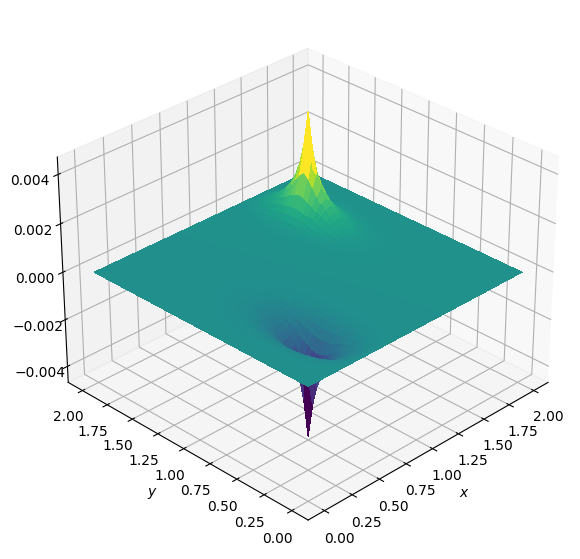

In [82]:

plot2D(x, y, p)

Ah! The wonders of code reuse! Now, you probably think: "Well, if I've written this neat little function that does something so useful, I want to use it over and over again. How can I do this without copying and pasting it each time? —If you are very curious about this, you'll have to learn about *packaging*. But this goes beyond the scope of our CFD lessons. You'll just have to Google it if you really want to know.

***

## Learn More

To learn more about the role of the Poisson equation in CFD, watch **Video Lesson 11** on You Tube:

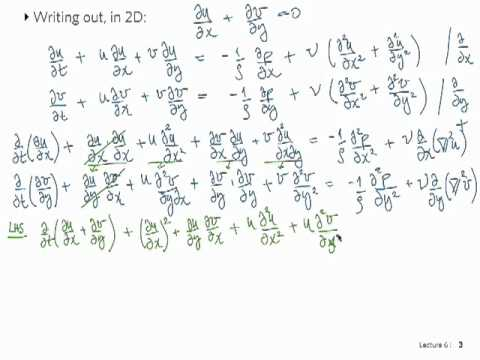

In [83]:
from IPython.display import YouTubeVideo
YouTubeVideo('ZjfxA3qq2Lg')

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

> (The cell above executes the style for this notebook.)